# Latents Study: Hyper-parameters study by Umap

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [2]:
%matplotlib inline

from importlib import reload
import os
import numpy as np

import pandas

import h5py
import seaborn as sns
import pandas as pd
import umap

from ulmo.analysis import io as analy_io
from ulmo.utils import image_utils
from ulmo import plotting
from ulmo import io as ulmo_io
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm.auto import trange

In [3]:
### Load the table
evals_path = '/home/jovyan/modis_dataset/MODIS_L2_std.feather'
evals_tbl = ulmo_io.load_main_table(evals_path)

Read main table: /home/jovyan/modis_dataset/MODIS_L2_std.feather


In [4]:
### Load the latents file
lat_file = '/home/jovyan/modis_dataset/' \
           'MODIS_R2019_2019_95clear_128x128_latents_std.h5'
l_h5 = h5py.File(lat_file, 'r')
latents = l_h5['latents']
latents.shape

(751689, 512)

## Show the latents_embedding

In [5]:
### At first let's get the index list of the latent vectors. Here we thank Prof. X for his nice 'matching' codes.
y2019 = evals_tbl.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
### Check the total number of the number of latents
assert np.sum(y2019) == latents.shape[0], 'The index list is not consistent with the latent array!'
print(f'The total number of latents is: {np.sum(y2019)}.')
### Get the index list of the latent vector
idx = evals_tbl[y2019].pp_idx.values
ll_pd = evals_tbl[y2019].LL
assert ll_pd.shape[0] == latents.shape[0], "The 'll' list is not consistent with the latent array!"

The total number of latents is: 751689.


In [7]:
### Here we write a funtion 'threshold_get()' to get the left and right threshold
def threshold_get(data_pd, alpha):
    """
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability

    Output:
        (left_threshold, right_threshold): (tuple (float, float))
    """
    p_left = (1 - alpha) / 2
    p_right = 1 - (1 - alpha) / 2
    q_left = data_pd.quantile(p_left)
    q_right = data_pd.quantile(p_right)
    
    return (q_left, q_right)

In [8]:
def hist_tail_create(data_pd, alpha):
    """
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability
    """
    q_left, q_right = threshold_get(data_pd, alpha)
    sns.histplot(evals_tbl[y2019].LL)
    plt.vlines(x=q_left, ymin=0, ymax=9000, color='red', linestyles='dashed')
    plt.vlines(x=q_right, ymin=0, ymax=9000, color='red', linestyles='dashed')
    plt.xlabel('LL', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.title(f'tail area = 1 - {alpha}', fontsize=25)

In [9]:
### Here we write a function 'outliers_preparing()' 
def outliers_preparing(data_pd, alpha):
    """
    Args:
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability

    Output:
        (left_outliers_indices, right_outliers_indices, normal_indices): (tuple (list, list, list))
    """
    q_left, q_right = threshold_get(data_pd, alpha)
    ll_latents_np = data_pd.values.copy()
    left_outliers_indices = np.argwhere(ll_latents_np <= q_left).squeeze()
    right_outliers_indices = np.argwhere(ll_latents_np >= q_right).squeeze()
    normal_indices_left = np.argwhere(q_left <= ll_latents_np).squeeze()
    normal_indices_right = np.argwhere(ll_latents_np <= q_right).squeeze()
    normal_indices = np.intersect1d(normal_indices_left, normal_indices_right)
    
    assert len(left_outliers_indices) + len(right_outliers_indices) + len(normal_indices) == len(ll_latents_np), \
        'the result is not consistent!'
    
    return (left_outliers_indices, right_outliers_indices, normal_indices)

In [10]:
def scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices):
    """
    Args:
        latents_embedding: (np.array) The array of reduced manifold
        left_outliers_indices: (np.array) The array of left tail indices
        right_outliers_indices: (np.array) The array of right tail indices
        normal_indices: (np.array) The array of normal indices
    """
    plt.scatter(latents_embedding[:, 0][normal_indices], latents_embedding[:, 1][normal_indices],
            s=12, label='normal')
    plt.scatter(latents_embedding[:, 0][left_outliers_indices], latents_embedding[:, 1][left_outliers_indices],
            s=30, label='left outliers')
    plt.scatter(latents_embedding[:, 0][right_outliers_indices], latents_embedding[:, 1][right_outliers_indices],
            s=30, label='right outliers')
    plt.xlabel('1st dimension', fontsize=15)
    plt.ylabel('2ed dimension', fontsize=15)
    plt.legend(fontsize=15, loc=1)
    plt.title('Scatter plot of embedding manifold by UMAP', fontsize=25)

In [ ]:
### Crerate the function 'hist_and_scatter_create()'
def hist_and_scatter_create(latents_embedding, data_pd, alpha):
    """
    Args:
        latents_embedding: (np.array) reduced manifolds
        data_pd: (pd.dataframe): the sample set
        alpha: (float) the confidence probability
    """
    plt.figure(figsize=(22, 8))
    plt.subplot(1, 2, 1)
    hist_tail_create(data_pd, alpha)
    plt.subplot(1, 2, 2)
    left_outliers_indices, right_outliers_indices, normal_indices = outliers_preparing(data_pd, alpha)
    scatter_create(latents_embedding, left_outliers_indices, right_outliers_indices, normal_indices)

### Set n_neighbors = 50

In [ ]:
### Hyper-parameters in Umap
n_neighbors = 50
min_dist = 0.2
n_components = 3
metric = 'cosine'

In [ ]:
%time
reducer_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
#reducer_umap = umap.UMAP()
latents_embedding = reducer_umap.fit_transform(latents)
print('The shape of the reduced matrix is: ', latents_embedding.shape)
print('The dimension of the embedding manifold is: ', latents_embedding.shape[1])

### Show the plot with tail area as $1 - 0.99$

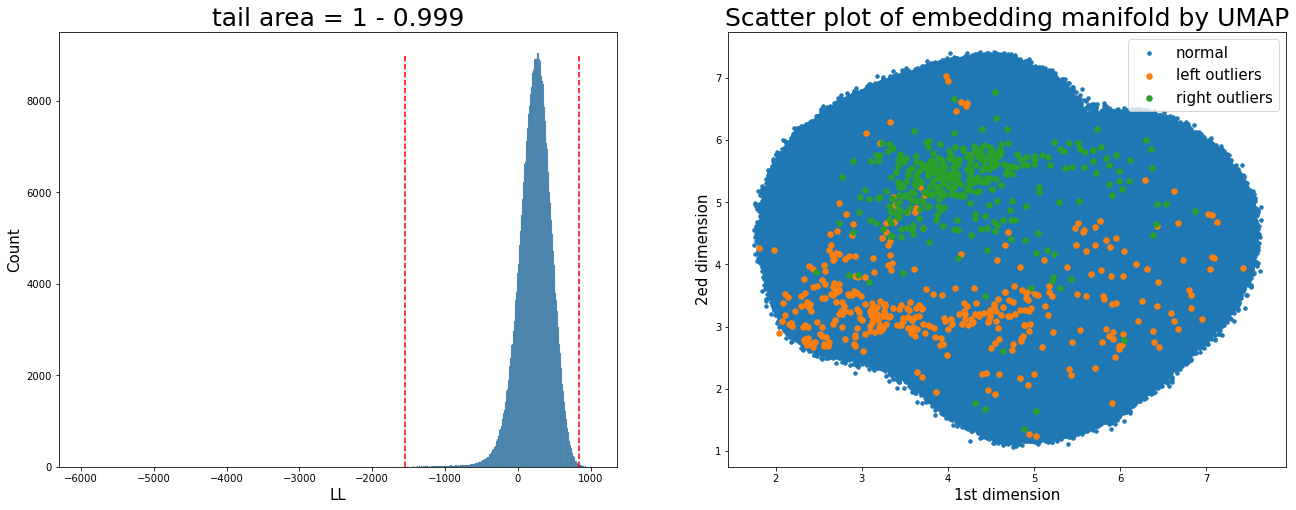

In [26]:
### Test of 'hist_and_scatter_create()'
ll_pd = evals_tbl[y2019].LL
alpha = 0.999
hist_and_scatter_create(latents_embedding, ll_pd, alpha)

### Use min_dist = 0.05

In [27]:
### Hyper-parameters in Umap
n_neighbors = 50
min_dist = 0.05
n_components = 3
metric = 'cosine'

In [28]:
%%time
reducer_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
latents_embedding = reducer_umap.fit_transform(latents)
print('The shape of the reduced matrix is: ', latents_embedding.shape)
print('The dimension of the embedding manifold is: ', latents_embedding.shape[1])

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 46.5 µs
The shape of the reduced matrix is:  (751689, 3)
The dimension of the embedding manifold is:  3


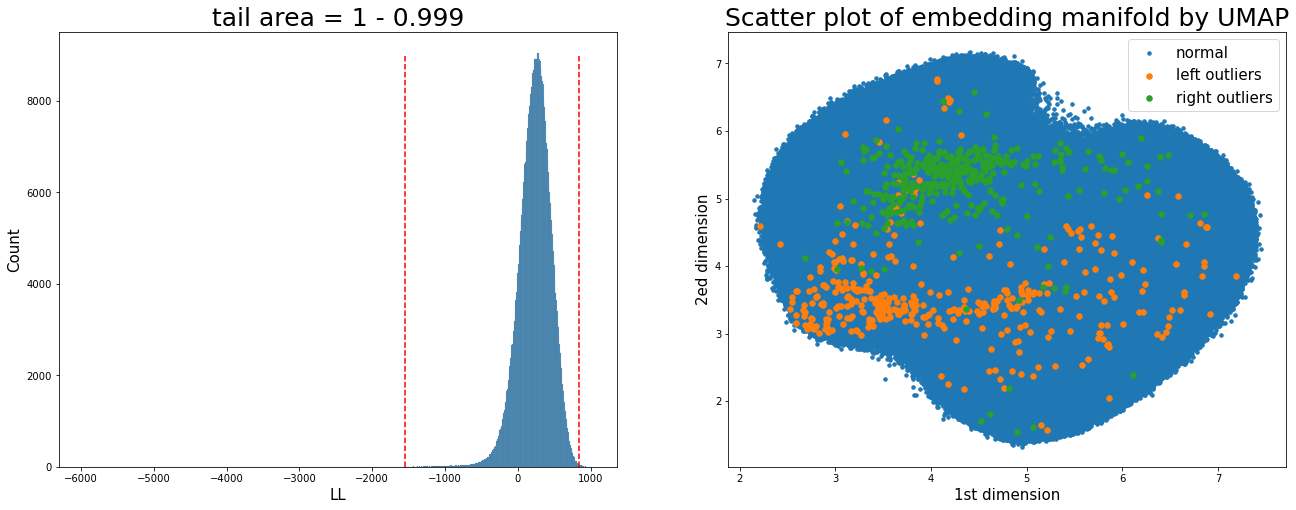

In [30]:
### Test of 'hist_and_scatter_create()'
ll_pd = evals_tbl[y2019].LL
alpha = 0.999
hist_and_scatter_create(latents_embedding, ll_pd, alpha)

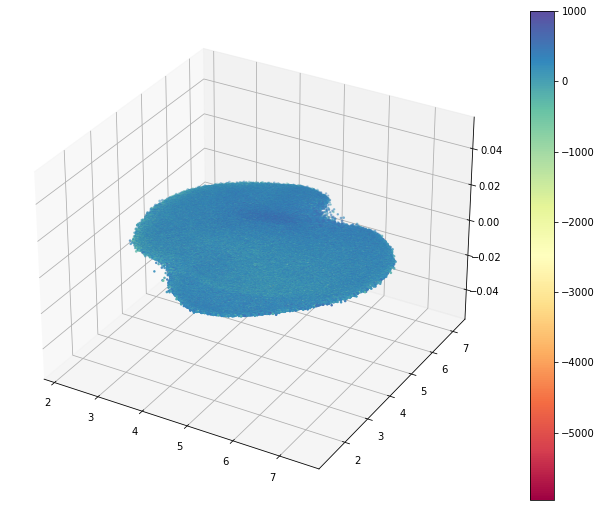

In [50]:
### Test of 'hist_and_scatter_create()'
ll_pd = evals_tbl[y2019].LL
alpha = 0.999
plt.figure(figsize=(12, 9))
plt.subplot(projection='3d')
plt.scatter(latents_embedding[:, 0], latents_embedding[:, 1], latents_embedding[:, 2], c=ll_pd, cmap='Spectral')
plt.colorbar()

## create the function to study the hyper-parameters

In [6]:
def draw_umap(hyper_dict, latents, ll):
    """
    Args:
        hyper_dict: (dict) dictionary used to store the hyper-parameters
        latents: (np.array) latent vectors
        ll: (pd.dataframe) likelihood of the latents
        
    """
    n_neighbors = hyper_dict['n_neighbors']
    min_dist = hyper_dict['min_dist']
    n_components = hyper_dict['n_components']
    metric = hyper_dict['metric']
    title = hyper_dict['title']
    
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    reduced_latents = reducer.fit_transform(latents);
    fig = plt.figure(figsize=(11, 8))
    if n_components == 1:
        plt.scatter(reduced_latents[:,0], range(len(reduced_latents)), c=ll, cmap='Spectral')
        plt.colorbar()
    if n_components == 2:
        plt.scatter(reduced_latents[:,0], reduced_latents[:,1], c=ll, cmap='Spectral')
        plt.colorbar()
    #if n_components == 3:
    #    plt.subplot(projection='3d')
    #    plt.scatter(reduced_latents[:,0], reduced_latents[:,1], reduced_latents[:,2], c=data, s=100)
    plt.title(title, fontsize=18)

### Let's study the 'n_neighbors' parameters at first

In [7]:
n_neighbors_list = [2, 20, 200, 2000]
n_neighbors = 0
min_dist = 0.01
n_components = 2
metric = 'euclidean'
title = f'n_neighbors is: {n_neighbors}'
parameters = {'n_neighbors': n_neighbors, 
              'min_dist': min_dist, 
              'n_components': n_components, 
              'metric': metric, 
              'title': title}

In [8]:
n_neighbors = 200
parameters['n_neighbors'] = n_neighbors

CPU times: user 19h 11min, sys: 1h 35min 36s, total: 20h 46min 37s
Wall time: 58min 29s


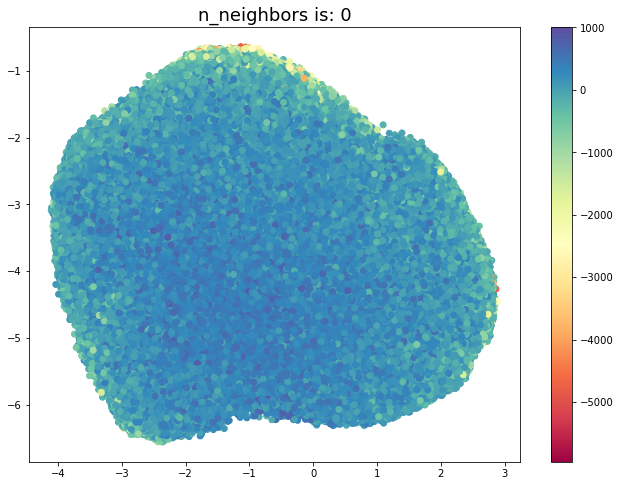

In [9]:
%%time
draw_umap(parameters, latents, ll_pd)

### conlusion:
* From above plot, we conclude that with increasing 'n_neighbors', the computation of the Umap increases at the same time

In [ ]:
%%time
for i in trange(len(n_neighbors_list)):
    parameters['n_neighbors'] = n_neighbors_list[i]
    draw_umap(parameters, latents, ll_pd)